In [126]:
from mpl_toolkits.mplot3d import Axes3D 
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Ellipse
from scipy.stats import multivariate_normal
from sklearn.datasets import make_spd_matrix
from sklearn.datasets import make_sparse_spd_matrix
plt.rcParams["axes.grid"] = False
import matplotlib.image as mpimg
import os
import scipy

### Set up location and scale for the random gaussian data

In [127]:
c_2D =7
dots_2D = 1000
sprad_2D = 20
eps = 1e-8

In [128]:
labels_2D = np.array(range(0,c_2D))
labels_2D = np.repeat(labels_2D, dots_2D)
mu_x_2D = np.random.random_integers(-sprad_2D,sprad_2D+1,c_2D)
mu_y_2D = np.random.random_integers(-sprad_2D,sprad_2D+1,c_2D)

C:\Users\dorli\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: This function is deprecated. Please call randint(-20, 21 + 1) instead
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\dorli\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: This function is deprecated. Please call randint(-20, 21 + 1) instead
  after removing the cwd from sys.path.


# Create the data from Normal distributions

In [129]:
mean_2D = np.zeros((c_2D,2))
cov_2D = np.zeros((c_2D,2,2))
for i in range(0,c_2D):
    mean_2D[i,0] = mu_x_2D[i]
    mean_2D[i,1] = mu_y_2D[i]
    cov_2D[i,:,:] = make_spd_matrix(2) #+ np.identity(2) * np.random.random_sample()

In [130]:
X_data_2D = np.zeros((c_2D*dots_2D,2))
for i in range(0,c_2D):
    X_data_2D[i*dots_2D:(i+1)*dots_2D,:] = np.random.multivariate_normal(mean_2D[i], cov_2D[i], dots_2D)
original_data = X_data_2D.copy()

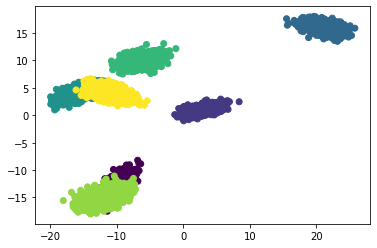

In [131]:
fig = plt.figure()
ax = fig.add_subplot(111)
# plot x,y data with c as the color vector, set the line width of the markers to 0
ax.scatter(X_data_2D[:,0], X_data_2D[:,1], c = labels_2D)

In [132]:
np.random.shuffle(X_data_2D)

# Help Functions

In [133]:
def initialize_first_center(X_data_2D):
    return [np.mean(X_data_2D[:,0]),np.mean(X_data_2D[:,1])]

In [134]:
def compute_dist_from_center(center_k, X_data_2D):
    return np.linalg.norm(X_data_2D - center_k, axis=1)

In [135]:
def compute_fuzzy_covariance_matrix(k, X_data_2D, centers, U_k, q):
    F_k = []
    for c in range(0,k):
        cov =  (U_k[c][0]**q) * np.outer(X_data_2D[0,:]-centers[c], (X_data_2D[0,:]-centers[c]).T)
        for i in range(1,X_data_2D.shape[0]):
            cov = cov + ((U_k[c][i]**q) * np.outer(X_data_2D[i,:]-centers[c], (X_data_2D[i,:]-centers[c]).T))
        F_c = cov / np.sum(U_k[c] ** q)
        F_k.append(F_c)
    return np.array(F_k)

In [136]:
def compute_HPV(k, F_k):
    h_k = 0
    for c in range(0,k):
        h_k = h_k + np.linalg.det(F_k[c]) ** (1/2)
    return h_k 

In [137]:
# Normalized partition index criterion
def compute_NPIC(k, X_data_2D, centers, U_k, F_k, q):
    J = 0 
    for c in range(0,k):
        dist_c = compute_dist_from_center(centers[c], X_data_2D)
        J = J + np.sum(np.multiply(U_k[c] ** q , dist_c))
    return J * k

In [138]:
# PD Central 
def compute_PDC(k, X_data_2D, centers, U_k, F_k):
    C_k = 0
    for c in range(0,k):
        cond = np.multiply(np.dot((X_data_2D - centers[c]), np.linalg.pinv(F_k[c])), (X_data_2D - centers[c]))
        I_k = np.argwhere(cond[:,0]*cond[:,1] < 1)
        C_k = C_k + np.sum(U_k[c][I_k])
        
    h_k = compute_HPV(k, F_k)
    return C_k / h_k

In [139]:
# PD Maximun
def compute_PDM(k, X_data_2D, centers, U_k, F_k):
    m_k = 0
    for c in range(0,k):     
        m_k = m_k + np.max(U_k[c])
    h_k = compute_HPV(k, F_k)
    return m_k / h_k

In [140]:
def compute_APDC(k, X_data_2D, centers, U_k, F_k):
    pdc = compute_PDC(k, X_data_2D, centers, U_k, F_k)
    return pdc/k

In [141]:
def compute_APDM(k, X_data_2D, centers, U_k, F_k):
    pdm = compute_PDM(k, X_data_2D, centers, U_k, F_k)
    return pdm/k

In [142]:
def compute_statistics(k, X_data_2D, centers, U_k, F_k , q):
    HPV = compute_HPV(k, F_k)
    PDC = compute_PDC(k, X_data_2D, centers, U_k, F_k)
    PDM = compute_PDM(k, X_data_2D, centers, U_k, F_k)
    APDC = compute_APDC(k, X_data_2D, centers, U_k, F_k)
    APDM = compute_APDM(k, X_data_2D, centers, U_k, F_k)
    NPIC = compute_NPIC(k, X_data_2D, centers, U_k, F_k, q)
    INV = compute_INV(k, X_data_2D, centers, U_k, F_k, q)
    J_D = compute_J_D(k, X_data_2D, centers, U_k, F_k, q)
    return [HPV, PDC, PDM, APDC, APDM, NPIC, INV, J_D]

In [143]:
def new_centers_list(prev_centers, X_data_2D):
    new_centers_array = np.zeros((prev_centers.shape[0] + 1, 2))    
    new_centers_array[:prev_centers.shape[0],:] = prev_centers
    new_centers_array[prev_centers.shape[0],:] = initialize_first_center(X_data_2D)
    return new_centers_array

In [144]:
def compute_membership_matrix_for_new_center(k, X_data_2D, centers, q):
    memb_mat = []
    dist_sum = (compute_dist_from_center(centers[0], X_data_2D) ** (-2/(q-1)))
    for c in range(1,k-1):
        dist_sum = dist_sum + (compute_dist_from_center(centers[c], X_data_2D) ** (-2/(q-1)))
    last_center = compute_dist_from_center(centers[k-1], X_data_2D)
    last_center.fill((np.max(dist_sum) + np.max(last_center))**4)
    dist_sum = dist_sum + (last_center ** (-2/(q-1)))
    for c in range(0,k-1):
        dist_c = (compute_dist_from_center(centers[c], X_data_2D) ** (-2/(q-1))) / dist_sum
        memb_mat.append(dist_c)
    dist_c = (last_center ** (-2/(q-1))) / dist_sum
    memb_mat.append(dist_c)
    return np.array(memb_mat)

In [145]:
def compute_membership_matrix(k, X_data_2D, centers, q):
    memb_mat = []
    dist_sum = (compute_dist_from_center(centers[0], X_data_2D) ** (-2/(q-1)))
    for c in range(1,k):
        dist_sum = dist_sum + (compute_dist_from_center(centers[c], X_data_2D) ** (-2/(q-1)))
    for c in range(0,k):
        dist_c = (compute_dist_from_center(centers[c], X_data_2D) ** (-2/(q-1))) / dist_sum
        memb_mat.append(dist_c)
    return np.array(memb_mat)

In [146]:
def compute_centers_given_membership_matrix(k, X_data_2D, U_k, centers, q):
    new_centers = np.zeros(np.array(centers).shape)
    for c in range(0,k):
        new_centers[c] = [np.sum(np.multiply(X_data_2D[:,0], U_k[c] ** q)), np.sum(np.multiply(X_data_2D[:,1], U_k[c] ** q))] / np.sum(U_k[c] ** q)
    return new_centers

In [147]:
#1. do the fuzzy k_mean 
    # update the center according to membership matrix 
    # update the membership matrix using the center 
    # do it until it converge 
def fuzzy_K_mean(k, X_data_2D, centers, q, U_k):
    new_centers = compute_centers_given_membership_matrix(k, X_data_2D, U_k, centers, q)
    max_iter = 200
    cur_it = 0
    while np.max(np.abs(new_centers-centers)) > 0.001 and cur_it < max_iter:
        centers = new_centers
        U_k = compute_membership_matrix(k, X_data_2D, centers, q)
        new_centers = compute_centers_given_membership_matrix(k, X_data_2D, U_k, centers, q)
        cur_it = cur_it + 1
    return np.array(centers), np.array(U_k) 

In [148]:
#2. do the fuzzy MLE using gaussian distance 
def fuzzy_MLE(k, X_data_2D, centers, q, U_k):
    F_k = compute_fuzzy_covariance_matrix(k, X_data_2D, centers, U_k, q)
    a_k = np.mean(U_k, axis=1)
    U_k = compute_MLE_membership_matrix(k, X_data_2D, centers, q, a_k, F_k)
    new_centers = compute_centers_given_membership_matrix(k, X_data_2D, U_k, centers, q)
    
    max_iter = 200
    cur_it = 0
    while np.max(np.abs(new_centers-centers)) > 0.001 and cur_it < max_iter:
        centers = new_centers
        F_k = compute_fuzzy_covariance_matrix(k, X_data_2D, centers, U_k, q)
        a_k = np.mean(U_k, axis=1)
        U_k = compute_MLE_membership_matrix(k, X_data_2D, centers, q, a_k, F_k)
        new_centers = compute_centers_given_membership_matrix(k, X_data_2D, U_k, centers, q)
        cur_it = cur_it + 1
    return np.array(centers), np.array(U_k) 

In [149]:
def compute_MLE_membership_matrix(k, X_data_2D, centers, q, a_k, F_k):
    memb_mat = []
    dist_sum = (compute_MLE_dist_from_center(centers[0], X_data_2D, a_k[0], F_k[0]) ** (-2/(q-1)))
    for c in range(1,k):
        dist_sum = dist_sum + (compute_MLE_dist_from_center(centers[c], X_data_2D, a_k[c], F_k[c]) ** (-2/(q-1)))
    for c in range(0,k):
        dist_c = (compute_MLE_dist_from_center(centers[c], X_data_2D, a_k[c], F_k[c]) ** (-2/(q-1))) / dist_sum
        memb_mat.append(dist_c)
    return np.array(memb_mat)

In [150]:
def compute_INV(k, X_data_2D, centers, U_k, F_k, q):
    S_B = calc_S_B(k, X_data_2D, centers, U_k, q)
    S_W = calc_S_W(k, X_data_2D, centers)
    return np.trace(np.dot(np.linalg.inv(S_W), S_B))

In [151]:
#TODO: add q to call 
def calc_S_B(k, X_data_2D, centers, U_k, q):
    ni = np.mean(U_k**(2*q), axis=0)    
    c_mean = np.mean(centers, axis=0)
    S_B = np.zeros((2,2))
    for c in range(0,k):    
        S_B = S_B + ni[c] * np.outer((centers[c] - c_mean), (centers[c] - c_mean).T)
    return S_B

In [214]:
def compute_MLE_dist_from_center(center_k, X_data_2D, a_k, F_k):
    A = (np.linalg.det(F_k) ** 0.5) / a_k
    B_tag = np.dot(np.dot((X_data_2D - center_k), np.linalg.pinv(F_k)), (X_data_2D - center_k).T).diagonal()
    B = np.exp(B_tag/2)
    return A * B

In [190]:
def compute_J_D(k, X_data_2D, centers, U_k, F_k, q):
    S_B = calc_S_B(k, X_data_2D, centers, U_k, q)
    S_W = calc_S_W(k, X_data_2D, centers)
    S_T = S_W + S_B
    return np.trace(np.dot(np.linalg.inv(S_T), S_B))

In [154]:
def calc_S_W(k, X_data_2D, centers):
    S_W = np.zeros((2,2))
    for c in range(0,k):
        for i in range(0,X_data_2D.shape[0]):
            S_W = S_W + np.outer(X_data_2D[i,:]-centers[c], (X_data_2D[i,:]-centers[c]).T)
    return S_W 

# Unsupervised Optimal Fuzzy Clustering

### Set up global parameters 

In [232]:
X_data_2D = circles


C_min = 1 
C_max = 10
q = 3 #controls the fuzziness 
F_k = []
statistics = [] 
U_k = []
centers = []
k = 1 

#plotting Flag!
plot_color = False
plotting = True

print("k has to be: "+ str(C_min)+" < k < " + str(C_max))
print("initialize k with: ", k)
print("fuzziness critiria: q =", q)

k has to be: 1 < k < 10
initialize k with:  1
fuzziness critiria: q = 3


### Initialize the model with the first center 

In [233]:
first_center  = np.array([initialize_first_center(X_data_2D)])

#initialize centers list with the first center! 
centers.append(first_center)
print("first center:", first_center[0])

first center: [4.99761019 5.05167361]


##### The mean and var of the first cluster is the mean and variance of the input

Plot Data and First Center


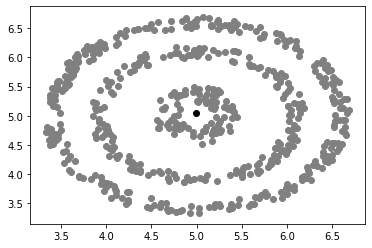

In [234]:
print("Plot Data and First Center")
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(X_data_2D[:,0], X_data_2D[:,1], color='grey')
ax.scatter(first_center[0][0], first_center[0][1], color='black')

# Loop Step 

(2, 2)
(2, 2)
(2, 2)
number of clusters in this iter is:  1
statistics for iter: 0
HPV:  1.1711961734490104
PDC:  518.8399048379116
PDM:  1.1711961734490104
APDC:  518.8399048379116
APDM:  1.1711961734490104
NPIC:  736.1405700997065
INV:  0.0
J_D:  0.0


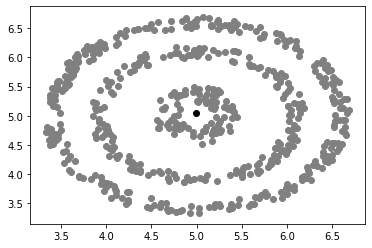

(2, 2)
(2, 2)
(2, 2)
number of clusters in this iter is:  2
statistics for iter: 1
HPV:  1.2052008724701688
PDC:  554.1541534215681
PDM:  2.365516510163316
APDC:  277.07707671078407
APDM:  1.182758255081658
NPIC:  1367.2171201217905
INV:  0.0002762471328675253
J_D:  0.0002761708414643891


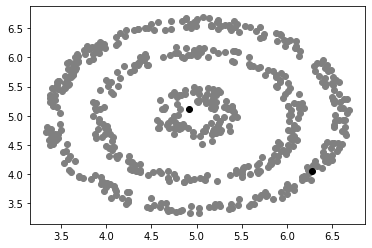

(2, 2)
(2, 2)
(2, 2)
number of clusters in this iter is:  3
statistics for iter: 2
HPV:  1.377472101285079
PDC:  669.2551395156864
PDM:  4.114760562116154
APDC:  223.0850465052288
APDM:  1.371586854038718
NPIC:  1485.0395920580931
INV:  0.00038437784814531536
J_D:  0.0003843037189116867


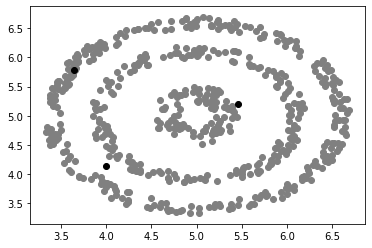

(2, 2)
(2, 2)
(2, 2)
number of clusters in this iter is:  4
statistics for iter: 3
HPV:  1.446978888941883
PDC:  665.5150087473722
PDM:  5.756652850683796
APDC:  166.37875218684306
APDM:  1.439163212670949
NPIC:  1550.097712919897
INV:  0.0003626570930773678
J_D:  0.000362587863577483


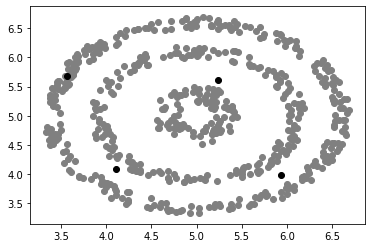

(2, 2)
(2, 2)
(2, 2)
number of clusters in this iter is:  5
statistics for iter: 4
HPV:  1.6447904610882038
PDC:  807.0999030893291
PDM:  8.22381674332331
APDC:  161.41998061786583
APDM:  1.644763348664662
NPIC:  1409.5155440579472
INV:  0.000287030513123575
J_D:  0.0002869893220227344


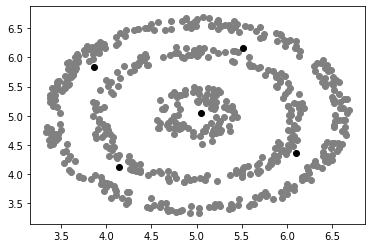

(2, 2)
(2, 2)
(2, 2)
number of clusters in this iter is:  6
statistics for iter: 5
HPV:  1.6816598107702279
PDC:  833.7304395367023
PDM:  10.088731627228645
APDC:  138.95507325611706
APDM:  1.6814552712047741
NPIC:  1625.5679408710973
INV:  0.0001782899744356746
J_D:  0.0001782732613084153


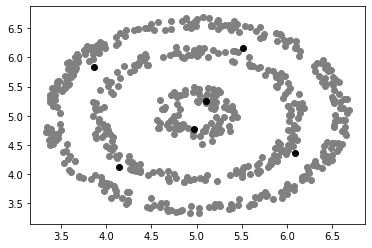

(2, 2)
(2, 2)
(2, 2)
number of clusters in this iter is:  7
statistics for iter: 6
HPV:  1.7028042801860657
PDC:  834.3755042760837
PDM:  11.91786801496518
APDC:  119.1965006108691
APDM:  1.7025525735664542
NPIC:  1856.9945568166136
INV:  0.00012073182964246384
J_D:  0.00012072328186541317


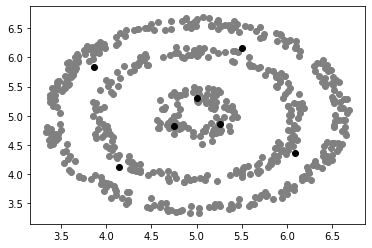

(2, 2)
(2, 2)
(2, 2)
number of clusters in this iter is:  8
statistics for iter: 7
HPV:  1.701291309043096
PDC:  816.5242158056316
PDM:  13.56515910888302
APDC:  102.06552697570395
APDM:  1.6956448886103774
NPIC:  1844.88901723459
INV:  0.00015637067466705478
J_D:  0.0001563583927126321


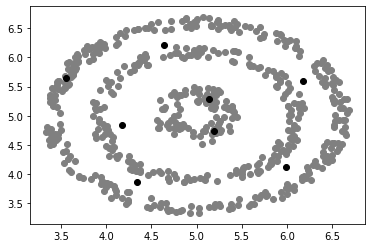

(2, 2)
(2, 2)
(2, 2)
number of clusters in this iter is:  9
statistics for iter: 8
HPV:  1.823719006719892
PDC:  898.4215266635628
PDM:  16.396244962439656
APDC:  99.8246140737292
APDM:  1.8218049958266285
NPIC:  2108.7718591050857
INV:  0.00013383518782344612
J_D:  0.00013382609176458739


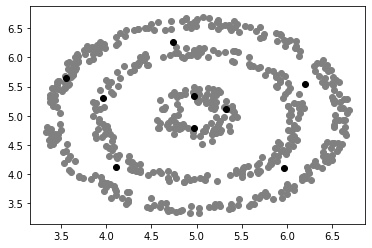

(2, 2)
(2, 2)
(2, 2)
number of clusters in this iter is:  10
statistics for iter: 9
HPV:  1.843928376869342
PDC:  906.4280208279381
PDM:  18.410401499422616
APDC:  90.6428020827938
APDM:  1.8410401499422615
NPIC:  2298.847332839402
INV:  0.00011723187770666877
J_D:  0.00011722491918114498


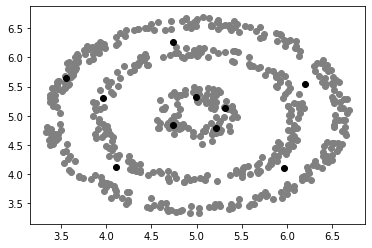

In [235]:
# The main loop 
for it in range(0, C_max):
    
    if it == 0: 
        # if we are in the first iter calculate the distance and membership matrix regularly 
        U_k.append(compute_membership_matrix(k, X_data_2D, centers[it], q))
    else:
        # otherwise, calculate them using the "trick" of given the new center equal distances from each data point
        U_k.append(compute_membership_matrix_for_new_center(k, X_data_2D, centers[it], q))
    
    centers[it], U_k[it] = fuzzy_K_mean(k, X_data_2D, centers[it], q, U_k[it])
    
    centers[it], U_k[it] = fuzzy_MLE(k, X_data_2D, centers[it], q, U_k[it])
    
    F_k.append(compute_fuzzy_covariance_matrix(k, X_data_2D, centers[it], U_k[it], q))
    
    [HPV, PDC, PDM, APDC, APDM, NPIC, INV, J_D] = compute_statistics(k, X_data_2D, centers[it], U_k[it], F_k[it], q)
    
    statistics.append(np.array([HPV, PDC, PDM, APDC, APDM, NPIC, INV, J_D]))
    
    #add a new centuer to the next centers list, intialize it with mean and var of the data
    centers.append(new_centers_list(centers[it], X_data_2D))
    #update number of centers for next iter:
    k = k + 1
    
    #plottting and statistics 
    if plotting == True:
        print("number of clusters in this iter is: ", k-1)
        print("statistics for iter:", it)
        print("HPV: ", 1/HPV)
        print("PDC: ", PDC)
        print("PDM: ", PDM)
        print("APDC: ", APDC)
        print("APDM: ", APDM)
        print("NPIC: ", NPIC)
        print("INV: ", INV)
        print("J_D: ", J_D)
        fig = plt.figure()
        ax = fig.add_subplot(111)
        if plot_color == True : 
            ax.scatter(X_data_2D[:,0], X_data_2D[:,1], c = labels_2D)
        else: 
            ax.scatter(X_data_2D[:,0], X_data_2D[:,1], color='grey')
        ax.scatter(centers[it][:,0], centers[it][:,1], color='black')
        plt.show()
    

# Plotting Statistics: 

In [236]:
statistics = np.array(statistics)
for i in range(statistics.shape[0]):
    print("statistics for iter",i,":")
    print(statistics[i])

statistics for iter 0 :
[  0.85382793 518.83990484   1.17119617 518.83990484   1.17119617
 736.1405701    0.           0.        ]
statistics for iter 1 :
[8.29737202e-01 5.54154153e+02 2.36551651e+00 2.77077077e+02
 1.18275826e+00 1.36721712e+03 2.76247133e-04 2.76170841e-04]
statistics for iter 2 :
[7.25967516e-01 6.69255140e+02 4.11476056e+00 2.23085047e+02
 1.37158685e+00 1.48503959e+03 3.84377848e-04 3.84303719e-04]
statistics for iter 3 :
[6.91095086e-01 6.65515009e+02 5.75665285e+00 1.66378752e+02
 1.43916321e+00 1.55009771e+03 3.62657093e-04 3.62587864e-04]
statistics for iter 4 :
[6.07980180e-01 8.07099903e+02 8.22381674e+00 1.61419981e+02
 1.64476335e+00 1.40951554e+03 2.87030513e-04 2.86989322e-04]
statistics for iter 5 :
[5.94650591e-01 8.33730440e+02 1.00887316e+01 1.38955073e+02
 1.68145527e+00 1.62556794e+03 1.78289974e-04 1.78273261e-04]
statistics for iter 6 :
[5.87266553e-01 8.34375504e+02 1.19178680e+01 1.19196501e+02
 1.70255257e+00 1.85699456e+03 1.20731830e-04 1.2

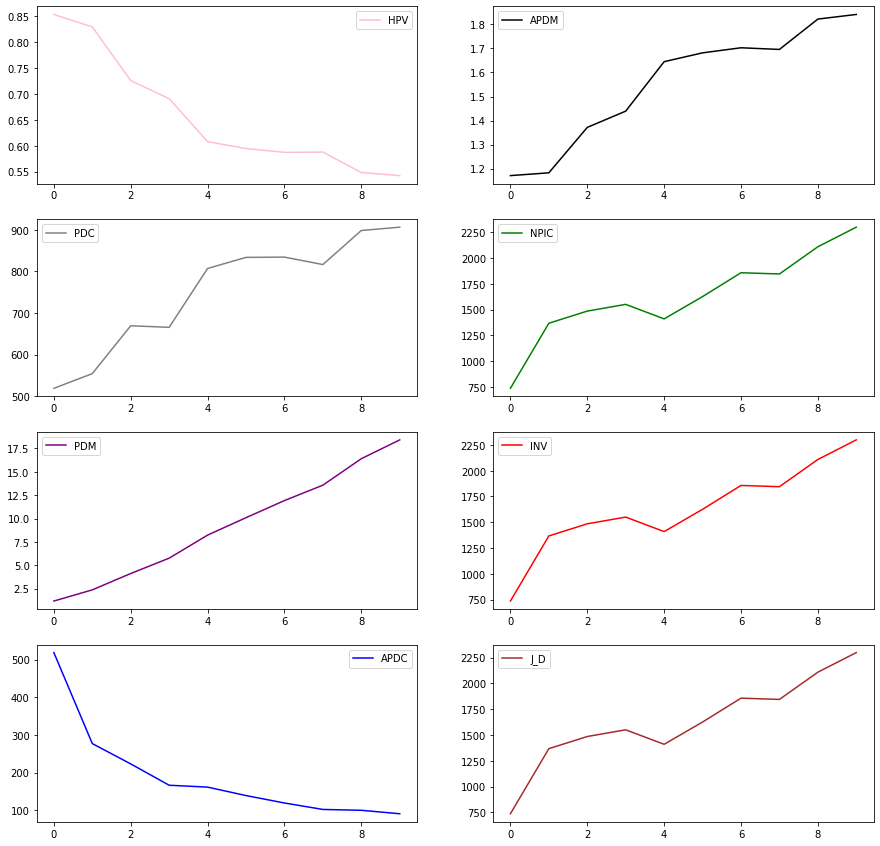

In [237]:
# [HPV, PDC, PDM, APDC, APDM, NPIC, INV, J_D]

# Plot the data
fig, axes = plt.subplots(4, 2, figsize=(15,15))
axes[0, 0].plot(np.array(range(statistics.shape[0])), statistics[:,0], label='HPV', color='pink')
axes[1, 0].plot(np.array(range(statistics.shape[0])), statistics[:,1], label='PDC', color='grey')
axes[2, 0].plot(np.array(range(statistics.shape[0])), statistics[:,2], label='PDM', color='purple')
axes[3, 0].plot(np.array(range(statistics.shape[0])), statistics[:,3], label='APDC', color='blue')
axes[0, 1].plot(np.array(range(statistics.shape[0])), statistics[:,4], label='APDM', color='black')
axes[1, 1].plot(np.array(range(statistics.shape[0])), statistics[:,5], label='NPIC', color='green')
axes[2, 1].plot(np.array(range(statistics.shape[0])), statistics[:,5], label='INV', color='red')
axes[3, 1].plot(np.array(range(statistics.shape[0])), statistics[:,5], label='J_D', color='brown')

axes[0, 0].legend()
axes[1, 0].legend()
axes[2, 0].legend()
axes[3, 0].legend()
axes[0, 1].legend()
axes[1, 1].legend()
axes[2, 1].legend()
axes[3, 1].legend()


In [238]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets
from sklearn.decomposition import PCA

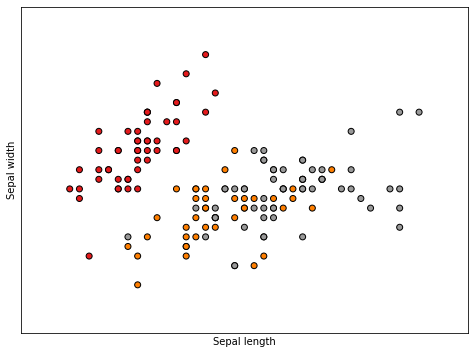

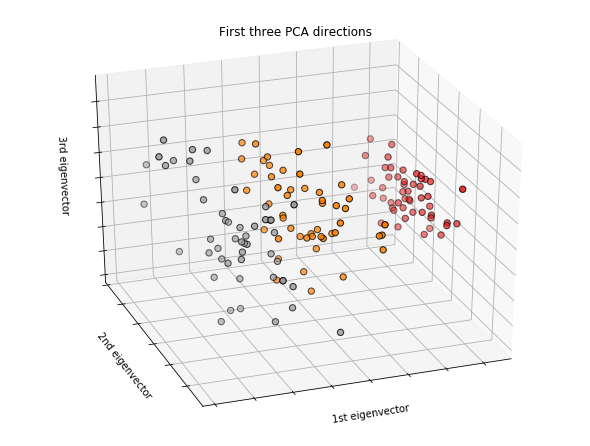

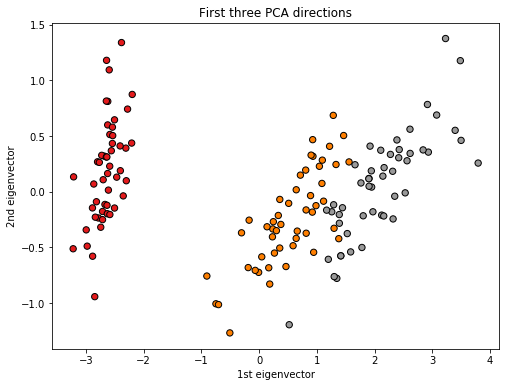

In [239]:
# import some data to play with
iris = datasets.load_iris()
X = iris.data[:, :2]  # we only take the first two features.
y = iris.target

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5

plt.figure(2, figsize=(8, 6))
plt.clf()

# Plot the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Set1,
            edgecolor='k')
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())

# To getter a better understanding of interaction of the dimensions
# plot the first three PCA dimensions
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)
X_reduced = PCA(n_components=3).fit_transform(iris.data)
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=y,
           cmap=plt.cm.Set1, edgecolor='k', s=40)
ax.set_title("First three PCA directions")
ax.set_xlabel("1st eigenvector")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.w_zaxis.set_ticklabels([])

plt.show()


# To getter a better understanding of interaction of the dimensions
# plot the first three PCA dimensions
fig = plt.figure(1, figsize=(8, 6))
ax = fig.add_subplot(111)
X_reduced = PCA(n_components=2).fit_transform(iris.data)
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y,
           cmap=plt.cm.Set1, edgecolor='k', s=40)
ax.set_title("First three PCA directions")
ax.set_xlabel("1st eigenvector")
ax.set_ylabel("2nd eigenvector")
plt.show()


iris_3 = np.array([X_reduced[:, 0], X_reduced[:, 1]]).T


C:\Users\dorli\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


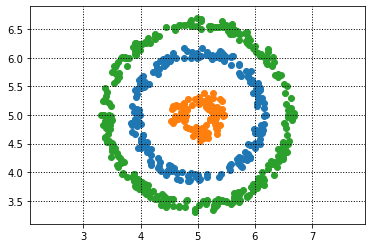

In [240]:
import matplotlib.pyplot as plt
from math import pi, cos, sin
import random

def point(h, k, r_start, r_stop):
    r = random.uniform(r_start, r_stop)
    theta = random.random() * 2 * pi
    return h + cos(theta) * r, k + sin(theta) * r
center_x = 5
center_y = 5
xy = [point(center_x,center_y,1,1.2) for _ in range(200)]
another_circle = [point(center_x,center_y,0.2,0.5) for _ in range(100)]
another_circle2 = [point(center_x,center_y,1.5,1.7) for _ in range(300)]

plt.scatter(*zip(*xy))
plt.scatter(*zip(*another_circle))
plt.scatter(*zip(*another_circle2))
plt.grid(color='k', linestyle=':', linewidth=1)
plt.axes().set_aspect('equal', 'datalim')
plt.show()

cir = np.array(xy)
cir1 = np.array(another_circle)
cir2 = np.array(another_circle2)
circles = np.concatenate((cir1, cir), axis=0)
circles = np.concatenate((circles, cir2), axis=0)